### Import Libraries

In [ ]:
import torch
from torch import nn
from PIL import Image
from torchvision import transforms
import itertools
from torch.utils.data import DataLoader
from torchvision import transforms
import time
import numpy as np
import os
import argparse
import random
from PIL import Image
import torch.utils.data as data
import argparse
import matplotlib.pyplot as plt
import math
from scipy.signal import periodogram


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
EEG_all = torch.from_numpy(np.load('/content/drive/MyDrive/Data/EEG_all_epochs.npy'))
EMG_all = torch.from_numpy(np.load('/content/drive/MyDrive/Data/EMG_all_epochs.npy'))
EOG_all = torch.from_numpy(np.load('/content/drive/MyDrive/Data/EOG_all_epochs.npy'))
noise_all = {
    'Occular' : EOG_all,
    'EMG' : EMG_all
}
EMG_all.shape

torch.Size([5598, 512])

### preperation of Data

In [ ]:
def random_signal(signal,combin_num):
    # Random disturb and augment signal
    random_result=[]
    signal = np.array(signal)

    for i in range(combin_num):
        random_num = np.random.permutation(signal.shape[0])
        shuffled_dataset = signal[random_num, :]
        shuffled_dataset = shuffled_dataset.reshape(signal.shape[0],signal.shape[1])
        random_result.append(shuffled_dataset)

    random_result  = torch.from_numpy(np.array(random_result))

    return  random_result

### Define Metrices

In [ ]:
import scipy.signal

def get_rms(records):

    return torch.sqrt(sum([x ** 2 for x in records]) / len(records))

def rrmse_temporal(x,y):
  '''
  X is refference signal
  y is the network output
  '''
  a = (get_rms((y-x))/get_rms(x))
  return a

def rrmse_spectral(x, y):
  """
  Calculates the relative root mean square error (RRMSEspectral) between two signals in the frequency domain.
  :param x: Input signal 1 (reference signal).
  :param y: Input signal 2 (comparison signal).
  :return: RRMSEspectral between x and y.
  """
  # Calculate PSD of x and y
  (f_x, psd_x) = scipy.signal.periodogram(x, 256, scaling='density')
  (f_y, psd_y) = scipy.signal.periodogram(y, 256, scaling='density')
  psd_x = psd_x[0:120]
  psd_y = psd_y[0:120]
  a = rrmse_temporal(torch.from_numpy(psd_x),torch.from_numpy(psd_y))
  return a

def correlation_coefficient(x, y):
    x_mean = torch.mean(x)
    y_mean = torch.mean(y)
    cov = torch.mean((x - x_mean) * (y - y_mean))
    var_x = torch.mean((x - x_mean)**2)
    var_y = torch.mean((y - y_mean)**2)
    cc = cov / (torch.sqrt(var_x) * torch.sqrt(var_y))
    return cc

In [ ]:
def prepare_data(EEG_all, noise_all, combin_num, train_per, noise_type):
    # Here we use eeg and noise signal to generate scale transed training, validation, test signal

    EEG_all_random = torch.squeeze(random_signal(signal = EEG_all, combin_num = 1))
    noise_all_random = torch.squeeze(random_signal(signal = noise_all, combin_num = 1))

    if noise_type == 'EMG':  # Training set will Reuse some of the EEG signal to much the number of EMG
        reuse_num = noise_all_random.shape[0] - EEG_all_random.shape[0]
        EEG_reuse = EEG_all_random[0 : reuse_num, :]
        EEG_all_random = torch.vstack([EEG_reuse, EEG_all_random])
        print('EEG segments after reuse: ',EEG_all_random.shape[0])

    elif noise_type == 'EOG':  # We will drop some of the EEG signal to much the number of EMG
        EEG_all_random = EEG_all_random[0:noise_all_random.shape[0]]
        print('EEG segments after drop: ',EEG_all_random.shape[0])


    # get the
    timepoint = noise_all_random.shape[1] #####
    train_num = round(train_per * EEG_all_random.shape[0]) # the number of segmentations used in training process
    validation_num = round((EEG_all_random.shape[0] - train_num) / 2) # the number of segmentations used in validation process
    #test_num = EEG_all_random.shape[0] - train_num - validation_num  # Rest are the number of segmentations used in test process

    train_eeg = EEG_all_random[0 : train_num, :]
    validation_eeg = EEG_all_random[train_num : train_num + validation_num, :]
    test_eeg = EEG_all_random[train_num + validation_num : EEG_all_random.shape[0], :]

    train_noise = noise_all_random[0 : train_num, :]
    validation_noise = noise_all_random[train_num : train_num + validation_num,:]
    test_noise = noise_all_random[train_num + validation_num : noise_all_random.shape[0], :]

    EEG_train = random_signal(signal = train_eeg, combin_num = combin_num).reshape(combin_num * train_eeg.shape[0], timepoint)
    NOISE_train = random_signal(signal = train_noise, combin_num = combin_num).reshape(combin_num * train_noise.shape[0], timepoint)

    #print(EEG_train.shape)
    #print(NOISE_train.shape)

    #################################  simulate noise signal of training set  ##############################

    #create random number between -10dB ~ 2dB
    SNR_train_dB = np.random.uniform(-7, 2, (EEG_train.shape[0]))
    print(SNR_train_dB.shape)
    SNR_train = 10 ** (0.1 * (SNR_train_dB))

    # combin eeg and noise for training set
    noiseEEG_train=[]
    NOISE_train_adjust=[]
    for i in range (EEG_train.shape[0]):
        eeg=EEG_train[i].reshape(EEG_train.shape[1])
        noise=NOISE_train[i].reshape(NOISE_train.shape[1])

        coe=get_rms(eeg)/(get_rms(noise)*SNR_train[i])
        noise = noise*coe
        neeg = noise+eeg

        NOISE_train_adjust.append(noise)
        noiseEEG_train.append(neeg)

    noiseEEG_train = torch.stack(noiseEEG_train)
    NOISE_train_adjust = torch.stack(NOISE_train_adjust)

    # variance for noisy EEG
    EEG_train_end_standard = []
    noiseEEG_train_end_standard = []
    STD_noiseEEG_train = []
    for i in range(noiseEEG_train.shape[0]):
        # Each epochs divided by the standard deviation
        STD_noiseEEG_train.append(torch.std(noiseEEG_train[i]))
        eeg_train_all_std = EEG_train[i] / torch.std(noiseEEG_train[i])
        EEG_train_end_standard.append(eeg_train_all_std)

        noiseeeg_train_end_standard = noiseEEG_train[i] / torch.std(noiseEEG_train[i])
        noiseEEG_train_end_standard.append(noiseeeg_train_end_standard)

    noiseEEG_train_end_standard = torch.stack(noiseEEG_train_end_standard)
    EEG_train_end_standard = torch.stack(EEG_train_end_standard)
    STD_noiseEEG_train = torch.from_numpy(np.array(STD_noiseEEG_train))
    print('training data prepared', noiseEEG_train_end_standard.shape, EEG_train_end_standard.shape )

    #################################  simulate noise signal of validation  ##############################

    SNR_val_dB = np.linspace(-7.0, 2.0, num=(10))
    SNR_val = 10 ** (0.1 * (SNR_val_dB))

    eeg_val = torch.from_numpy(np.array(validation_eeg))
    noise_val = torch.from_numpy(np.array(validation_noise))

    # combin eeg and noise for test set
    EEG_val = []
    noise_EEG_val = []
    for i in range(10):

        noise_eeg_val = []

        for j in range(eeg_val.shape[0]):
            eeg = eeg_val[j]
            noise = noise_val[j]

            coe = get_rms(eeg) / (get_rms(noise) * SNR_val[i])
            noise = noise * coe
            neeg = noise + eeg

            noise_eeg_val.append(neeg)

        EEG_val.extend(eeg_val)
        noise_EEG_val.extend(noise_eeg_val)


    noise_EEG_val = torch.stack(noise_EEG_val)
    EEG_val = torch.stack(EEG_val)


    # std for noisy EEG
    EEG_val_end_standard = []
    noiseEEG_val_end_standard = []
    STD_noiseEEG_val = []
    # std_VALUE = []
    for i in range(noise_EEG_val.shape[0]):

        # store std value to restore EEG signal
        std_value = torch.std(noise_EEG_val[i])
        STD_noiseEEG_val.append(std_value)
        #std_VALUE.append(std_value)

        # Each epochs of eeg and neeg was divide by the standard deviation
        eeg_val_all_std = EEG_val[i] / std_value
        EEG_val_end_standard.append(eeg_val_all_std)

        noiseeeg_val_end_standard = noise_EEG_val[i] / std_value
        noiseEEG_val_end_standard.append(noiseeeg_val_end_standard)

    #std_VALUE = np.array(std_VALUE)
    STD_noiseEEG_val = torch.from_numpy(np.array(STD_noiseEEG_val))
    noiseEEG_val_end_standard = torch.stack(noiseEEG_val_end_standard)
    EEG_val_end_standard = torch.stack(EEG_val_end_standard)
    print('validation data prepared, validation data shape: ', noiseEEG_val_end_standard.shape, EEG_val_end_standard.shape)

    #################################  simulate noise signal of test  ##############################

    SNR_test_dB = np.linspace(-7.0, 2.0, num=(10))
    SNR_test = 10 ** (0.1 * (SNR_test_dB))

    eeg_test = torch.from_numpy(np.array(test_eeg))
    noise_test = torch.from_numpy(np.array(test_noise))

    # combin eeg and noise for test set
    EEG_test = []
    noise_EEG_test = []
    for i in range(10):

        noise_eeg_test = []
        for j in range(eeg_test.shape[0]):
            eeg = eeg_test[j]
            noise = noise_test[j]

            coe = get_rms(eeg) / (get_rms(noise) * SNR_test[i])
            noise = noise * coe
            neeg = noise + eeg

            noise_eeg_test.append(neeg)

        EEG_test.extend(eeg_test)
        noise_EEG_test.extend(noise_eeg_test)


    noise_EEG_test = torch.stack(noise_EEG_test)
    EEG_test = torch.stack(EEG_test)


    # std for noisy EEG
    EEG_test_end_standard = []
    noiseEEG_test_end_standard = []
    STD_noiseEEG_test = []
    for i in range(noise_EEG_test.shape[0]):

        # store std value to restore EEG signal
        std_value = torch.std(noise_EEG_test[i])
        STD_noiseEEG_test.append(std_value)

        # Each epochs of eeg and neeg was divide by the standard deviation
        eeg_test_all_std = EEG_test[i] / std_value
        EEG_test_end_standard.append(eeg_test_all_std)

        noiseeeg_test_end_standard = noise_EEG_test[i] / std_value
        noiseEEG_test_end_standard.append(noiseeeg_test_end_standard)

    STD_noiseEEG_test = torch.from_numpy(np.array(STD_noiseEEG_test))
    noiseEEG_test_end_standard = torch.stack(noiseEEG_test_end_standard)
    EEG_test_end_standard = torch.stack(EEG_test_end_standard)
    print('test data prepared, test data shape: ', noiseEEG_test_end_standard.shape, EEG_test_end_standard.shape)

    return noiseEEG_train_end_standard, EEG_train_end_standard,STD_noiseEEG_train, noiseEEG_val_end_standard, EEG_val_end_standard,STD_noiseEEG_val, noiseEEG_test_end_standard, EEG_test_end_standard, STD_noiseEEG_test


### MODEL

In [ ]:
class ResnetGenerator(nn.Module):
    #Generator architecture
    def __init__(self, input_nc=1, output_nc=1, inter_nc=64,dim2=512, n_blocks=6, use_bias = False, rs_norm = 'BN', padding_type = 'zero', dsple = False,K=3):
        # input_nc(int) -- The number of channels of input img
        # output_nc(int) -- The number of channels of output img
        # inter_nc(int) -- The number of filters of intermediate layers
        # n_blocks(int) -- The number of resnet blocks
        # img_size(int) -- Input image size
        # use_bias(bool) -- Whether to use bias on conv layer or not
        # rs_norm(str) -- The type of normalization method of ResnetBlock. BN : Batch Normalization, IN : Instance Normalization, else : none
        # padding_type(str) -- The name of padding layer: reflect | replicate | zero
        # dsple(bool) -- Whether to downsample or maintain input image. Set it true for G3.
        # scale_factor(int) -- Scale factor, 2 / 4
        super(ResnetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.inter_nc = inter_nc
        self.n_blocks = n_blocks
        self.use_bias = use_bias
        self.rs_norm = rs_norm
        self.padding_type = padding_type
        self.dsple = dsple
        self.dim2 = dim2
        torch.autograd.set_detect_anomaly(True)

        # Input blocks
        InBlock = []

        InBlock += [nn.Conv1d(input_nc, inter_nc, kernel_size=K, stride=1, padding='same', bias=self.use_bias),
                     nn.LeakyReLU(0.2)]
        InBlock += [nn.Conv1d(inter_nc, inter_nc, kernel_size= K, stride=1, padding='same', bias=self.use_bias),
                     nn.LeakyReLU(0.2)] #changed
        InBlock += [nn.Conv1d(inter_nc, inter_nc, kernel_size= K, stride=1, padding='same', bias=self.use_bias),
                     nn.LeakyReLU(0.2)]

        # ResnetBlocks
        ResnetBlocks = []

        for i in range(n_blocks):
            ResnetBlocks += [ResnetBlock(inter_nc,self.dim2 ,self.padding_type, self.rs_norm, self.use_bias,K)]

        # Output block
        OutBlock = []

        OutBlock += [nn.Conv1d(inter_nc, inter_nc, kernel_size= K, stride=1, padding='same', bias=self.use_bias),
                     nn.LeakyReLU(0.2)]
        OutBlock += [nn.Conv1d(inter_nc, inter_nc, kernel_size= K, stride=1, padding='same', bias=self.use_bias),
                     nn.LeakyReLU(0.2)]
        OutBlock += [nn.Conv1d(inter_nc, output_nc, kernel_size= K, stride=1, padding='same', bias=self.use_bias),
                     nn.LeakyReLU(0.2)]

        self.InBlock = nn.Sequential(*InBlock)
        self.ResnetBlocks = nn.Sequential(*ResnetBlocks)
        self.OutBlock = nn.Sequential(*OutBlock)
    def forward(self,x):
        out = self.InBlock(x)
        out = self.ResnetBlocks(out)
        out = self.OutBlock(out)

        return out
class ResnetBlock(nn.Module):
    def __init__(self, dim,dim2, padding_type, norm_type, use_bias,K=3):
        # dim(int) -- The number of channels in the resnet blocks
        # padding_type(str) -- The name of padding layer: reflect | replicate | zero
        # norm_type(str) -- The type of normalization method. BN : Batch Normalization, IN : Instance Normalization, else : none
        # use_bias -- Whether to use bias on conv layer or not
        super(ResnetBlock, self).__init__()

        conv_block = []

        # Padding
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad1d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad1d(1)]
        elif padding_type == 'zero':
            p = 'same'
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        if norm_type=='BN':
            norm_layer = nn.BatchNorm1d
        elif norm_type=='IN':
            norm_layer = nn.InstanceNorm1d
        else:
            raise NotImplementedError('Normalization [%s] is not implemented' % norm_type)

        conv_block += [nn.Conv1d(dim, dim, kernel_size= K, padding=p, bias=use_bias),
                       norm_layer(dim2),
                       nn.LeakyReLU(0.2)]


        # Padding
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 'same'
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv1d(dim, dim, kernel_size= K, padding=p, bias=use_bias),
                       norm_layer(dim2),
                       nn.LeakyReLU(0.2)]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        out = self.conv_block(x)

        # Skip connection
        out = out + x

        return out


class Discriminator(nn.Module):
    def __init__(self, input_nc=1,dim2=512, norm_type = 'BN', use_bias = True, is_inner=True,K = 3):
        # input_nc(int) -- The number of channels of input img
        # norm_type(str) -- The type of normalization method. BN : Batch Normalization, IN : Instance Normalization, else : none
        # use_bias(bool) -- Whether to use bias or not
        # is_inner(bool) -- True : For inner cycle, False : For outer cycle
        # scale_factor(int) -- Scale factor, 2 / 4

        super(Discriminator, self).__init__()

        if norm_type=='BN':
            norm_layer = nn.BatchNorm1d
            use_bias = False # There is no need to use bias because BN already has shift parameter.
        elif norm_type=='IN':
            norm_layer = nn.InstanceNorm1d
        else:
            raise NotImplementedError('Normalization [%s] is not implemented' % norm_type)

        if is_inner == True:
            s = 1
        elif is_inner == False:
            s = 2
        else:
            raise NotImplementedError('is_inner must be boolean.')

        nfil_mul = 64
        p='same' # Why 1???
        layers = []

        layers += [nn.Conv1d(input_nc, nfil_mul, kernel_size= K, stride = 1, padding=p, bias=use_bias),
                       nn.LeakyReLU(0.2)] # changed
        layers += [nn.Conv1d(nfil_mul, nfil_mul*2, kernel_size=K, stride = 1, padding=p, bias=use_bias),
                       norm_layer(dim2),
                       nn.LeakyReLU(0.2)]
        layers += [nn.Conv1d(nfil_mul*2, nfil_mul*4, kernel_size= K, stride = 1, padding=p, bias=use_bias),
                       norm_layer(dim2),
                       nn.LeakyReLU(0.2)]
        layers += [nn.Conv1d(nfil_mul*4, nfil_mul*8, kernel_size= K, stride = 1, padding=p, bias=use_bias),
                       norm_layer(dim2),
                       nn.LeakyReLU(0.2)]
        layers += [nn.Conv1d(nfil_mul*8, 1, kernel_size=K, stride = 1, padding=p, bias=use_bias),
                       nn.LeakyReLU(0.2)]
        self.layers = nn.Sequential(*layers)

    def forward(self,x):
        out = self.layers(x)

        return out # Predicted values of each patches

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

device ='cpu'

EEG_all = EEG_all[:50,]
EOG_all = EOG_all[:50,]

X_train,y_train,STD_train,X_val,y_val,STD_val,X_test,y_test,STD_test = prepare_data(EEG_all, EOG_all, combin_num=5, train_per=.8, noise_type='EOG')

train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val_dataset = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

batch_size = 64
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

G1_forward = ResnetGenerator().to(device)
G1_backward = ResnetGenerator().to(device)
D1_forward = Discriminator().to(device)
D1_backward = Discriminator().to(device)

""" Define Loss """
MSE_loss = nn.MSELoss().to(device)
lr = 0.0001
eps = 1e-8

""" Optimizers """
G_optim = torch.optim.Adam(itertools.chain(G1_forward.parameters(), G1_backward.parameters()),lr=lr, betas=(0.5,0.999), eps = eps)
D_optim = torch.optim.Adam(itertools.chain(D1_forward.parameters(), D1_backward.parameters()),lr=lr, betas=(0.5,0.999), eps = eps)

train_history = {
    'train_loss_disc': [],
    'train_loss_g1': [],
    'T_rrmse' : [],
    'S_rrmse' : [],
    'Correlation Coef':[],
}
test_history = {
    'test_loss_disc': [],
    'test_loss_g1': [],
    'T_rrmse' : [],
    'S_rrmse' : [],
    'Correlation Coef':[],
}
valid_history = {
    'valid_loss_disc': [],
    'valid_loss_g1': [],
    'T_rrmse' : [],
    'S_rrmse' : [],
    'Correlation Coef':[],
}



EEG segments after drop:  50
(200,)
training data prepared torch.Size([200, 512]) torch.Size([200, 512])
validation data prepared, validation data shape:  torch.Size([50, 512]) torch.Size([50, 512])
test data prepared, test data shape:  torch.Size([50, 512]) torch.Size([50, 512])


In [ ]:
for data,target in trainloader:
      data = data.float()
      print(data.size())
print(X_test.size())
print(X_val.size())

torch.Size([64, 512])
torch.Size([64, 512])
torch.Size([64, 512])
torch.Size([8, 512])
torch.Size([50, 512])
torch.Size([50, 512])


Training

Epoch 1
63
Discrimintor loss 0.5580 on iteration 1
Generator loss 10.8107 on iteration 1
63
Discrimintor loss 0.5809 on iteration 2
Generator loss 8.8161 on iteration 2
63
Discrimintor loss 0.6129 on iteration 3
Generator loss 9.1366 on iteration 3
7
Discrimintor loss 0.5440 on iteration 4
Generator loss 9.0767 on iteration 4
train_loss_ discriminator 0.5440 and train_loss_generator 9.0767 for Epoch number 1
Validaion_loss_ discriminator 0.4301 and validation_loss_generator 8.8245 for Epoch number 1
Valid_temporal RRMSE 1.1314  for Epoch number 1
Valid_spectral RRMSE 2.8907  for Epoch number 1
Correlation Coefficient 0.5018  for Epoch number 1
Epoch 2
63
Discrimintor loss 0.5616 on iteration 5
Generator loss 8.5563 on iteration 5
63
Discrimintor loss 0.5277 on iteration 6
Generator loss 8.0043 on iteration 6
63
Discrimintor loss 0.5154 on iteration 7
Generator loss 8.4912 on iteration 7
7
Discrimintor loss 0.4935 on iteration 8
Generator loss 7.8791 on iteration 8
train_loss_ discrimin

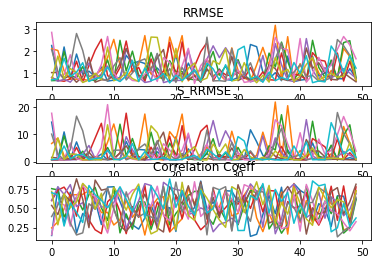

In [ ]:
cuda = torch.cuda.is_available()
import torch
torch.cuda.empty_cache()
w1 = 10
w2 = 5
num_epoch = 20
iter_freq = 2
p=0
for epoch in range(num_epoch):
    for model in [G1_forward, G1_backward, D1_forward, D1_backward]:
      model.train()
   # train_loss_disc = 0.0
    #train_loss_gen = 0.0
    print('Epoch',epoch+1)
    for data,target in trainloader:
      data = data.float()
      target = target.float()
      if cuda:
        data, target = data.to('cuda'), target.to('cuda')

      dis1_loss = 0.0
      g1_loss = 0.0
      p +=1
      for i in range(len(data)):
        data_n = data[i].unsqueeze(0)
        target_n = target[i].unsqueeze(0)
        fake_forward = G1_forward(data_n)
        fake_backward = G1_backward(target_n)
        #print(f"fake_forward.shape : {fake_forward.size()} fake_backward.shape : {fake_backward.size()} ")
        # D1 output for Clean EEG
        dis1_forward_output_real = D1_forward(target_n)
        dis1_backward_output_real = D1_backward(data_n)
        # D1 output for noisy EEG
        dis1_forward_output_fake = D1_forward(fake_forward)
        dis1_backward_output_fake = D1_backward(fake_backward)
        #print(f"dis1_forward_output_fake.shape : {dis1_forward_output_fake.size()} dis1_backward_output_fake.shape : {dis1_backward_output_fake.size()} ")
        # D1 prediction for clean EEG
        dis1_forward_predicted_real = torch.mean(dis1_forward_output_real, dim = [0,1])
        dis1_backward_predicted_real = torch.mean(dis1_backward_output_real, dim = [0,1])

        # D1 prediction for noisy EEG
        dis1_forward_predicted_fake = torch.mean(dis1_forward_output_fake, dim = [0,1])
        dis1_backward_predicted_fake = torch.mean(dis1_backward_output_fake, dim = [0,1])

        # Discriminator loss
        dis1_forward_ad_loss = MSE_loss(dis1_forward_predicted_fake, torch.zeros_like(dis1_forward_predicted_fake).to(device)) + MSE_loss(dis1_forward_predicted_real, torch.ones_like(dis1_forward_predicted_real).to(device))
        dis1_backward_ad_loss = MSE_loss(dis1_backward_predicted_fake, torch.zeros_like(dis1_backward_predicted_fake).to(device)) + MSE_loss(dis1_backward_predicted_real, torch.ones_like(dis1_backward_predicted_real).to(device))

        dis1_loss += dis1_forward_ad_loss + dis1_backward_ad_loss


        fake_forward = G1_forward(data_n)
        fake_backward = G1_backward(target_n)

        # D1 output for fake images
        dis1_forward_output_fake = D1_forward(fake_forward)
        dis1_backward_output_fake = D1_backward(fake_backward)

        # D1 prediction for fake images
        dis1_forward_predicted_fake = torch.mean(dis1_forward_output_fake, dim = [0,1])
        dis1_backward_predicted_fake = torch.mean(dis1_backward_output_fake, dim = [0,1])

        # Adversarial loss
        g1_forward_ad_loss = MSE_loss(dis1_forward_predicted_fake, torch.ones_like(dis1_forward_predicted_fake).to(device))
        g1_backward_ad_loss = MSE_loss(dis1_backward_predicted_fake, torch.ones_like(dis1_backward_predicted_fake).to(device))

        # Cycle consistency loss
        g1_forward_cycle_loss = MSE_loss(G1_backward(fake_forward), data_n)
        g1_backward_cycle_loss = MSE_loss(G1_forward(fake_backward), target_n)

        # Identity loss
        g1_forward_identity_loss = MSE_loss(G1_forward(target_n), target_n)
        g1_backward_identity_loss = MSE_loss(G1_backward(data_n), data_n)
        '''
        print('cycle loss',g1_forward_cycle_loss)
        print('identity',g1_forward_identity_loss)
        print('add', g1_forward_ad_loss)
        '''
        g1_forward_loss = g1_forward_ad_loss.item() + w1*g1_forward_cycle_loss + w2*g1_forward_identity_loss.item()
        g1_backward_loss = g1_backward_ad_loss.item() + w1*g1_backward_cycle_loss + w2*g1_backward_identity_loss.item()

        g1_loss +=  g1_forward_loss + g1_backward_loss

        '''
        print('forward loss',g1_forward_loss)
        print('backward loss',g1_backward_loss)
        print('ggggg',g1_loss)


        T_rrmse_train += rrmse_temporal(target_n,fake_forward)
        S_rrmse_train += rrmse_spectral(target_n,fake_forward)
        cc_train += correlation_coefficient(target_n,fake_forward)


        #train_loss_disc += dis1_loss.item()
        #train_loss_gen += g1_loss.item()
         '''
      print(i)
      D_optim.zero_grad()
      dis1_loss = dis1_loss/float(data.shape[0])
      print('Discrimintor loss %.4f on iteration %d'%(dis1_loss,p))
      dis1_loss.backward()
      D_optim.step()
      # Update Generator
      G_optim.zero_grad()
      g1_loss = g1_loss/float(data.shape[0])
      print('Generator loss %.4f on iteration %d'%(g1_loss,p))
      g1_loss.backward()
      G_optim.step()



    train_history[f'train_loss_disc'].append(dis1_loss.item())
    train_history[f'train_loss_g1'].append(g1_loss.item())


    print('train_loss_ discriminator %.4f and train_loss_generator %.4f for Epoch number %d' % (torch.tensor(np.array(train_history[f'train_loss_disc'][-1])),torch.tensor(np.array(train_history[f'train_loss_g1'][-1])),(epoch+1)))
    #print('train_temporal RRMSE %.4f  for Epoch number %d' % (torch.tensor(np.array(train_history[f'T_rrmse'][epoch])),(epoch+1)))
    #print('train_spectral RRMSE %.4f  for Epoch number %d' % (torch.tensor(np.array(train_history[f'S_rrmse'][epoch])),(epoch+1)))
    #print('Correlation Coefficient %.4f  for Epoch number %d' % (torch.tensor(np.array(train_history[f'Correlation Coef'][epoch])),(epoch+1)))
    if epoch%iter_freq ==0:
      with torch.no_grad():
        for model in [G1_forward, G1_backward, D1_forward, D1_backward]:
          model.eval()
        val_loss_disc = 0.0
        val_loss_gen = 0.0
        g1_loss_v = 0.0
        dis1_loss_v = 0.0
        A_Trmse = 0.0
        A_Srmse = 0.0
        A_cc = 0.0
        T_rrmse_val = []
        S_rrmse_val = []
        cc_val = []
        for data,target in valloader:
          data = data.float()
          target = target.float()
          if cuda:
            data, target = data.to('cuda'), target.to('cuda')
          for i in range(len(data)):
            data_n = data[i].unsqueeze(0)
            target_n = target[i].unsqueeze(0)
            fake_forward = G1_forward(data_n)
            fake_backward = G1_backward(target_n)
            #print(f"fake_forward.shape : {fake_forward.size()} fake_backward.shape : {fake_backward.size()} ")
            # D1 output for Clean EEG
            dis1_forward_output_real = D1_forward(target_n)
            dis1_backward_output_real = D1_backward(data_n)
            # D1 output for noisy EEG
            dis1_forward_output_fake = D1_forward(fake_forward)
            dis1_backward_output_fake = D1_backward(fake_backward)
            #print(f"dis1_forward_output_fake.shape : {dis1_forward_output_fake.size()} dis1_backward_output_fake.shape : {dis1_backward_output_fake.size()} ")
            # D1 prediction for clean EEG
            dis1_forward_predicted_real = torch.mean(dis1_forward_output_real, dim = [0,1])
            dis1_backward_predicted_real = torch.mean(dis1_backward_output_real, dim = [0,1])

            # D1 prediction for noisy EEG
            dis1_forward_predicted_fake = torch.mean(dis1_forward_output_fake, dim = [0,1])
            dis1_backward_predicted_fake = torch.mean(dis1_backward_output_fake, dim = [0,1])

            # Discriminator loss
            dis1_forward_ad_loss = MSE_loss(dis1_forward_predicted_fake, torch.zeros_like(dis1_forward_predicted_fake).to(device)) + MSE_loss(dis1_forward_predicted_real, torch.ones_like(dis1_forward_predicted_real).to(device))
            dis1_backward_ad_loss = MSE_loss(dis1_backward_predicted_fake, torch.zeros_like(dis1_backward_predicted_fake).to(device)) + MSE_loss(dis1_backward_predicted_real, torch.ones_like(dis1_backward_predicted_real).to(device))

            dis1_loss_v += dis1_forward_ad_loss + dis1_backward_ad_loss
            # Generator

            fake_forward = G1_forward(data_n)
            fake_backward = G1_backward(target_n)

            # D1 output for Noisy EEG
            dis1_forward_output_fake = D1_forward(fake_forward)
            dis1_backward_output_fake = D1_backward(fake_backward)

            # D1 prediction for noisy EEG
            dis1_forward_predicted_fake = torch.mean(dis1_forward_output_fake, dim = [0,1])
            dis1_backward_predicted_fake = torch.mean(dis1_backward_output_fake, dim = [0,1])

            # Adversarial loss
            g1_forward_ad_loss = MSE_loss(dis1_forward_predicted_fake, torch.ones_like(dis1_forward_predicted_fake).to(device))
            g1_backward_ad_loss = MSE_loss(dis1_backward_predicted_fake, torch.ones_like(dis1_backward_predicted_fake).to(device))

            # Cycle consistency loss
            g1_forward_cycle_loss = MSE_loss(G1_backward(fake_forward), data_n)
            g1_backward_cycle_loss = MSE_loss(G1_forward(fake_backward), target_n)

            # Identity loss
            g1_forward_identity_loss = MSE_loss(G1_forward(target_n), target_n)
            g1_backward_identity_loss = MSE_loss(G1_backward(data_n), data_n)


            g1_forward_loss = g1_forward_ad_loss + w1*g1_forward_cycle_loss + w2*g1_forward_identity_loss
            g1_backward_loss = g1_backward_ad_loss + w1*g1_backward_cycle_loss + w2*g1_backward_identity_loss


            g1_loss_v += g1_forward_loss + g1_backward_loss
            A_Trmse += rrmse_temporal(target_n.squeeze(),fake_forward.squeeze())
            A_Srmse += rrmse_spectral(target_n.squeeze(),fake_forward.squeeze())
            A_cc += correlation_coefficient(target_n.squeeze(),fake_forward.squeeze())
            T_rrmse_val.append(rrmse_temporal(target_n.squeeze(),fake_forward.squeeze()))
            S_rrmse_val.append(rrmse_spectral(target_n.squeeze(),fake_forward.squeeze()))
            cc_val.append(correlation_coefficient(target_n.squeeze(),fake_forward.squeeze()))


          val_loss_disc = dis1_loss_v.item()
          val_loss_gen = g1_loss_v.item()

          val_loss_disc /= float(data.shape[0])
          val_loss_gen /= float(data.shape[0])
          A_Trmse /= float(data.shape[0])
          A_Srmse /= float(data.shape[0])
          A_cc /= float(data.shape[0])

          valid_history[f'valid_loss_disc'].append(val_loss_disc)
          valid_history[f'valid_loss_g1'].append(val_loss_gen)
          valid_history[f'T_rrmse'].append(A_Trmse)
          valid_history[f'S_rrmse'].append(A_Srmse)
          valid_history[f'Correlation Coef'].append(A_cc)

          print('Validaion_loss_ discriminator %.4f and validation_loss_generator %.4f for Epoch number %d' % (torch.tensor(np.array(valid_history[f'valid_loss_disc'][-1])),torch.tensor(np.array(valid_history[f'valid_loss_g1'][-1])),(epoch+1)))
          print('Valid_temporal RRMSE %.4f  for Epoch number %d' % (torch.tensor(np.array(valid_history[f'T_rrmse'][-1])),(epoch+1)))
          print('Valid_spectral RRMSE %.4f  for Epoch number %d' % (torch.tensor(np.array(valid_history[f'S_rrmse'][-1])),(epoch+1)))
          print('Correlation Coefficient %.4f  for Epoch number %d' % (torch.tensor(np.array(valid_history[f'Correlation Coef'][-1])),(epoch+1)))

          plt.subplot(311)
          plt.plot(T_rrmse_val)
          plt.title('RRMSE')
          plt.subplot(312)
          plt.plot(S_rrmse_val)
          plt.title('S_RRMSE')
          plt.subplot(313)
          plt.plot(cc_val)
          plt.title('Correlation Coeff')
